<a href="https://colab.research.google.com/github/nedokormysh/GB_PyTorch/blob/lesson6/GB_PyTorch_hw_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание
1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

In [1]:
!pip install stop-words pymorphy2 -q

     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 8.2 MB 26.4 MB/s 


In [42]:
import torch
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import islice
from nltk.probability import FreqDist
import nltk
import numpy as np
import matplotlib.pyplot as plt

Загрузка датасета.

In [3]:
! mkdir ~/.kaggle
from google.colab import files

files.upload()

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download arkhoshghalb/twitter-sentiment-analysis-hatred-speech
! unzip -q '/content/twitter-sentiment-analysis-hatred-speech.zip'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Saving kaggle.json to kaggle.json
  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 188MB/s]


device(type='cuda', index=0)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
df_train = pd.read_csv('/content/train.csv')
print(df_train.shape)
df_train.head()

(31962, 3)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
df_test = pd.read_csv('/content/test.csv')
print(df_test.shape)
df_test.head()

(17197, 2)


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


В тестовом датасете нет лейблов. Поэтому для обучения и валидации будем использовать только датасет train.

In [7]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [8]:
df_train['label'].value_counts()[0] / df_train['label'].value_counts()[1]

13.256021409455842

In [9]:
random_state = 42

max_words = 1500
max_len = 15
num_classes = 1

# Training
epochs = 10
batch_size = 512
embedding_dim = 256
out_channel = 256

Несбалансированность классов будем исправлять за счёт стратификации.

In [10]:
X_train, X_val = train_test_split(df_train, 
                                  test_size=0.2, 
                                  random_state=random_state, 
                                  stratify=df_train['label'])

X_train.shape, X_val.shape

((25569, 3), (6393, 3))

In [11]:
X_train.head()

,id,label,tweet
26247,26248,0,did my first order at @user ð ... something...
13681,13682,1,"@user @user ð it's there, it's @user ðal..."
25676,25677,1,"@user video: @user on #hateful #liberals ""#am..."
14544,14545,0,@user @user after monaco a podium this time gu...
25411,25412,0,@user @user wow. us open amateur hour on fox. ...


## Преодобработка

In [12]:
sw = set(get_stop_words("en"))
sw.add('@user')
sw.add('user')
sw

{'@user',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'sh

In [13]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [14]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
def preprocess_text(txt):
    txt = str(txt)
    # уберем нечитаемые символы типа  ð\x9f¤\x97
    txt = "".join([c for c in txt if ord(c) < 128])
    txt = ''.join(char for char in txt if char not in puncts) # очистка от пунктуации
    txt = txt.lower()
    # преобразуем отрицания
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("no\s", "no", txt)
    
    txt = [lemmatizer.lemmatize(word) for word in txt.split()] # лемматизация
    txt = [word for word in txt if word not in sw]
    return ' '.join(txt)

In [16]:
from tqdm import tqdm 
tqdm.pandas()

X_train['tweet'] = X_train['tweet'].progress_apply(preprocess_text)
X_val['tweet'] = X_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 6393/6393 [00:00<00:00, 15239.90it/s]


Пример препроцессинга.

In [17]:
df_train['tweet'].iloc[:5].values

array([' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
       "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
       '  bihday your majesty',
       '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
       ' factsguide: society now    #motivation'], dtype=object)

In [18]:
df_train['tweet'].iloc[:5].apply(preprocess_text).values

array(['father dysfunctional selfish drag kid dysfunction run',
       'thanks lyft credit cant use cause dont offer wheelchair van pdx disapointed getthanked',
       'bihday majesty', 'model love u take u time ur',
       'factsguide society now motivation'], dtype=object)

Подготовим общий корпус текста:

In [143]:
train_corpus = " ".join(X_train["tweet"])
train_corpus = train_corpus.lower()
# train_corpus

In [20]:
len(train_corpus)

1422156

Сделаем токенизацию:

In [21]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['first',
 'order',
 'something',
 'black',
 'amp',
 'sexy',
 's',
 'collection',
 'cantwait',
 'although']

In [22]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [23]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1499

In [24]:
# Посмотрим на топ 10 слов
tokens_filtered_top[:10]

['love', 'day', 'happy', 'u', 'amp', 'just', 'will', 'life', 'time', 'im']

In [25]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [26]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [27]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train['tweet']])
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_val['tweet']])

x_train.shape, x_val.shape

CPU times: user 2.83 s, sys: 8.54 ms, total: 2.84 s
Wall time: 2.85 s


((25569, 15), (6393, 15))

In [28]:
X_train['tweet'].iloc[0]

'first order something black amp sexy s collection cantwait'

In [29]:
x_train[0]

array([  55,  482,  231,  127,    5,  298,  301, 1130,  586,    0,    0,
          0,    0,    0,    0])

Собираем сеть.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [31]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [32]:
train_dataset = DataWrapper(x_train, X_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, X_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Обучение модели.

In [34]:
model = Net(vocab_size=max_words, embedding_dim=embedding_dim, out_channel=out_channel)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

Net(
  (embedding): Embedding(1500, 256)
  (conv_1): Conv1d(256, 256, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=256, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 745217


In [139]:
def train_nn(th=0.5, vocab_size=max_words, embedding_dim=embedding_dim, out_channel=out_channel, learning_rate=1e-3, epochs=epochs, batch_size=batch_size, visual=False):

  random_state = 42

  max_words = 1500
  max_len = 15
  num_classes = 1

  # Training
  epochs = epochs
  batch_size = batch_size
  # embedding_dim = 256
  # out_channel = 256

  model = Net(vocab_size, embedding_dim, out_channel)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.BCELoss()

  print("Parameters of model:", sum([param.nelement() for param in model.parameters()]))

  model = model.to(device)
  model.train()
  th = 0.5

  train_loss_history = []
  test_loss_history = []
  train_f1_history = []
  test_f1_history = []

  for epoch in range(epochs):
  
    running_items, running_right = 0.0, 0.0
    tp, fp, tn, fn = 0, 0, 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

        tp += ((labels == 1) & (pred_labels == 1)).sum().item()
        tn += ((labels == 0) & (pred_labels == 0)).sum().item()
        fp += ((labels == 0) & (pred_labels == 1)).sum().item()
        fn += ((labels == 1) & (pred_labels == 0)).sum().item()

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          # f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}',
          f'F1-score: {f1_score:.3f}', end='. ')
    
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    tp, fp, tn, fn = 0, 0, 0, 0
    train_loss_history.append(loss)
    train_f1_history.append(f1_score)
    # print(train_f1_history)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    test_tp, test_fp, test_tn, test_fn = 0, 0, 0, 0

    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))

        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

        test_tp += ((test_labels == 1) & (pred_test_labels == 1)).sum().item()
        test_tn += ((test_labels == 0) & (pred_test_labels == 0)).sum().item()
        test_fp += ((test_labels == 0) & (pred_test_labels == 1)).sum().item()
        test_fn += ((test_labels == 1) & (pred_test_labels == 0)).sum().item()

    test_precision = test_tp / (test_tp + test_fp) if (test_tp + test_fp) != 0 else 0
    test_recall = test_tp / (test_tp + test_fn) if (test_tp + test_fn) != 0 else 0

    test_f1_score = 2 * test_precision * test_recall / (test_precision + test_recall) if (test_precision + test_recall) != 0 else 0
    
    test_loss_history.append(test_loss.item())
    test_f1_history.append(test_f1_score)
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}. Test F1_score: {test_f1_score:.3f}. Recall: {test_recall:.3f}')
    
    model.train()

  if visual is True:
   
    plt.title('F1 history')
    plt.grid(True)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(train_f1_history, label='train')
    plt.plot(test_f1_history, label='test')
    plt.legend();
        
  print('Training is finished!')

Parameters of model: 745217
Epoch [1/10]. Loss: 0.251. Acc: 0.923 F1-score: 0.011. Test loss: 0.187. Test acc: 0.930. Test F1_score: 0.000. Recall: 0.000
Epoch [2/10]. Loss: 0.183. Acc: 0.930 F1-score: 0.000. Test loss: 0.172. Test acc: 0.930. Test F1_score: 0.000. Recall: 0.000
Epoch [3/10]. Loss: 0.107. Acc: 0.944 F1-score: 0.424. Test loss: 0.132. Test acc: 0.948. Test F1_score: 0.466. Recall: 0.324
Epoch [4/10]. Loss: 0.090. Acc: 0.963 F1-score: 0.699. Test loss: 0.131. Test acc: 0.953. Test F1_score: 0.592. Recall: 0.491
Epoch [5/10]. Loss: 0.104. Acc: 0.976 F1-score: 0.816. Test loss: 0.343. Test acc: 0.954. Test F1_score: 0.602. Recall: 0.493
Epoch [6/10]. Loss: 0.047. Acc: 0.984 F1-score: 0.879. Test loss: 0.157. Test acc: 0.955. Test F1_score: 0.628. Recall: 0.542
Epoch [7/10]. Loss: 0.044. Acc: 0.990 F1-score: 0.929. Test loss: 0.101. Test acc: 0.948. Test F1_score: 0.615. Recall: 0.589
Epoch [8/10]. Loss: 0.033. Acc: 0.993 F1-score: 0.950. Test loss: 0.627. Test acc: 0.958. 

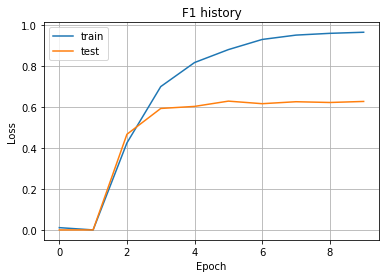

In [140]:
train_nn(visual=True)

Метрика accuracy  видимо совсем непрезентабельна с несбалансированными данными. Поэтому видимо следует оценивать качество модели по F1-score. Модель быстро переобучается. Возможно следует изменить конфигурацию сети, вероятно добавить слоёв дропаута или уменьшить количество признаков в свёрточных слоях. Также приходится учитывать соотношение количества эпох и скорости обучения, чтобы модель вообще обучалась. 

В принципе для модели поиска негативных отзывов нам более важна метрика recall.

In [142]:
train_nn(th=0.2, epochs=20)

Parameters of model: 745217
Epoch [1/20]. Loss: 0.211. Acc: 0.913 F1-score: 0.028. Test loss: 0.206. Test acc: 0.930. Test F1_score: 0.000. Recall: 0.000
Epoch [2/20]. Loss: 0.154. Acc: 0.930 F1-score: 0.000. Test loss: 0.194. Test acc: 0.930. Test F1_score: 0.000. Recall: 0.000
Epoch [3/20]. Loss: 0.123. Acc: 0.943 F1-score: 0.400. Test loss: 0.147. Test acc: 0.948. Test F1_score: 0.499. Recall: 0.371
Epoch [4/20]. Loss: 0.059. Acc: 0.962 F1-score: 0.684. Test loss: 0.127. Test acc: 0.951. Test F1_score: 0.595. Recall: 0.516
Epoch [5/20]. Loss: 0.043. Acc: 0.976 F1-score: 0.817. Test loss: 0.178. Test acc: 0.954. Test F1_score: 0.605. Recall: 0.507
Epoch [6/20]. Loss: 0.050. Acc: 0.985 F1-score: 0.887. Test loss: 0.200. Test acc: 0.957. Test F1_score: 0.602. Recall: 0.469
Epoch [7/20]. Loss: 0.038. Acc: 0.990 F1-score: 0.929. Test loss: 0.117. Test acc: 0.953. Test F1_score: 0.617. Recall: 0.545
Epoch [8/20]. Loss: 0.011. Acc: 0.993 F1-score: 0.948. Test loss: 0.309. Test acc: 0.949. 

При уменьшении значения threshold мы можем добиться улучшения характеристики Recall. При этом, конечно, мы допускаем больше ложноположительных срабатываний.